In [2]:
import numpy as np
import math

# import astropy.units as u
from matplotlib import pyplot as plt
import time
from numba import njit,prange
# import scipy.interpolate as interpl
# from numba.extending import overload
# from mpl_toolkits.mplot3d import axes3d
# from matplotlib import cm
# from matplotlib import pyplot as plt

In [18]:
@njit(boundscheck=True)
def trap(Vrf, Vdc):
    
    #define the trap parameters
    eps = 0.97413; #roughly the eccentricity
    f = 1; #flattening
    a = 0.05; #semi-minor axis
    c = 0.226*a; #distance from center to pole, semi major #0.293 is the exact like his photo, but doesn't give as good of a trap
    Rmin = 0.0114; #radius of the waist of the ellipsoid
    m = 0.01; #additional mirror thickness horizontal
    #t =  0.03; # the very top of the mirror
    #s = -0.035; # the bottom of the grounded part/the top of the RF part
    #u = -0.046965; # where the top of the laser opening is
    #d = -0.048465; # where the bottom of the laser opening is
    #b = -0.0509; # The bottom of the mirror block
    t =  0.03; # the very top of the mirror
    s = -0.0499;#-0.025; # the bottom of the grounded part/the top of the RF part
    u = -0.046965; # where the top of the laser opening is
    d = -0.048465; # where the bottom of the laser opening is
    u0 = 0.5*(u + d); # The z point of the optical focus (0, 0 , u0)
    slope = 0.5; #slope of line of laser slits
    b = -0.0509; # The bottom of the mirror block
    Rhole = 0.0009; #radius of the hole
    RholeLaser = 0.001; # Radius of the laser hole
    Hneedle = -0.0009; #height of needle inside trap up until the beginning of the needle tip
    Rneedle = 0.00023; #radius of needle
    HneedleTip = 0.0024; # height of needle tip from needle body
    RneedleTip = 0.0001; # The ball on top of the needle
    Bneedle = b; #where the needle begins
     
    
    #Properties of our grid
    gmax = 0.052 #physical size of the space simulated (meters)
    points = 401 # number of points that are being simulated
    steps = points - 1 # just the number of points minus one
    x = np.linspace(-gmax/2, gmax/2, points) #chosing how much space in the x, y, z direction, where it begins and where it ends
    y = np.linspace(-gmax/2, gmax/2, points)
    z = np.linspace(-gmax, 0, points)
    size = len(x) # telling it how to organize these spaces
    sizeZ = len(z)
    xmid = int((size)/2)
    ymid = int((size)/2)
    zmid = int((sizeZ)/2) 
    lattice_points=np.zeros((size**3,3))
    marker=0 #What do these mean?
    
    V0 = np.zeros((size, size, size)) #initialize the matrix for electric potential
    V0dc= np.zeros((size, size, size))
    V0_temp=np.zeros((size, size, size))
    V0dc_temp=np.zeros((size, size, size))
    cords=np.zeros((size, size, size, 3))
    iterations = 600 #number of iterations
    CenterV = np.zeros((iterations,1)) #keep track of the potential value at the center at each iteration
    
    # Now define the boundry conditions
    for i in range(len(x)):
        for j in range(len(y)):
            for k in range(len(z)):
                cords[i, j, k] = [i, j, k]
                    

                #The ellipsoidal mirror part 1, the laser slit and up
                if ((z[k] > (a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t) and (z[k] > slope*x[i] + u) and (z[k] > s)): #the top half of the ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((z[k] < -(a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < t) and (z[k] > slope*x[i] + u) and (z[k] > s)): #the bottom half of the ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((y[j] > np.sqrt(Rmin**2 - x[i]**2)) and (y[j] < Rmin + m) and (z[k] < t) and (z[k] > slope*x[i] + u) and (z[k] > s)): #other part of mirror going around the top of ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((y[j] < -np.sqrt(Rmin**2 - x[i]**2)) and (y[j] > -Rmin - m) and (z[k] < t) and (z[k] > slope*x[i] + u) and (z[k] > s)):#other part of mirror going around the bottom of ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((x[i] < Rmin + m) and (x[i] > Rmin) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t ) and (z[k] > slope*x[i] + u) and (z[k] > s)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((x[i] < - Rmin) and (x[i] > -Rmin - m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < t) and (z[k] > slope*x[i] + u) and (z[k] > s)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                    
                #The ellipsoidal mirror part 2, the laser slit and down
                elif ((z[k] > (a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < slope*x[i] + d) and (z[k] > s) and (z[k] < t)): #the top half of the ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((z[k] < -(a/c)* np.sqrt(c**2 - x[i]**2 -y[j]**2)) and (z[k] < slope*x[i] + d) and (z[k] > s) and (z[k] < t)): #the bottom half of the ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((y[j] > np.sqrt(Rmin**2 - x[i]**2)) and (y[j] < Rmin + m) and (z[k] < slope*x[i] + d) and (z[k] > s) and (z[k] < t)): #other part of mirror going around the top of ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((y[j] < -np.sqrt(Rmin**2 - x[i]**2)) and (y[j] > -Rmin - m) and (z[k] < slope*x[i] + d) and (z[k] > s) and (z[k] < t)):#other part of mirror going around the bottom of ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((x[i] < Rmin + m) and (x[i] > Rmin) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < slope*x[i] + d) and (z[k] > s) and (z[k] < t)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((x[i] < - Rmin) and (x[i] > -Rmin - m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] < slope*x[i] + d) and (z[k] > s) and (z[k] < t)): # to make an even square around ellipsoid
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                    
                # Bottom of the ellipsoidal mirror part 1, the laser slit and up
                elif ((x[i] > np.sqrt(Rhole**2 - y[j]**2)) and (x[i] < Rmin + m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] <= s) and (z[k] > b)):
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((x[i] < -np.sqrt(Rhole**2 - y[j]**2)) and (x[i] > -Rmin - m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] <= s) and (z[k] > b)): # and (z[k] > slope*x[i] + u)):
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((x[i] > -Rmin - m) and (y[j] < -Rhole) and (x[i] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] <= s) and (z[k] > b)):
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                elif ((x[i] < Rmin + m) and (y[j] > Rhole) and (y[j] < Rmin + m) and (x[i] > -Rmin - m) and (z[k] <= s) and (z[k] > b)):
                    V0[i, j, k] = Vrf[0]
                    V0dc[i, j, k] = Vdc[0]
                    
                # Bottom of the ellipsoidal mirror part 2, the laser slit and down
                elif ((x[i] > np.sqrt(Rhole**2 - y[j]**2)) and (x[i] < Rmin + m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] <= s) and (z[k] > b)):
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((x[i] < -np.sqrt(Rhole**2 - y[j]**2)) and (x[i] > -Rmin - m) and (y[j] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] <= s) and (z[k] > b)):# and (z[k] < slope*x[i] + d)):
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((x[i] > -Rmin - m) and (y[j] < -Rhole) and (x[i] < Rmin + m) and (y[j] > -Rmin - m) and (z[k] <= s) and (z[k] > b)):
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                elif ((x[i] < Rmin + m) and (y[j] > Rhole) and (y[j] < Rmin + m) and (x[i] > -Rmin - m) and (z[k] <= s) and (z[k] > b)):
                    V0[i, j, k] = Vrf[1]
                    V0dc[i, j, k] = Vdc[1]
                    
                #The needle
                elif ((y[j] < np.sqrt(Rneedle - x[i]**2)) and (x[i] < Rneedle) and (x[i] > -Rneedle) and (y[j] > -np.sqrt(Rneedle - x[i]**2)) and (y[j] < Rneedle) and (y[j] > -Rneedle) and (z[k] > -Bneedle) and (z[k] < -Bneedle + Hneedle)):
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                #The needle tip
                elif ((z[k] < - np.sqrt(x[i]**2 + y[j]**2)*12.5) and (x[i] < Rneedle) and (x[i] > -Rneedle) and (y[j] > -Rneedle) and (y[j] < Rneedle) and (z[k] > -Bneedle + Hneedle) and (z[k] < -Bneedle + Hneedle + HneedleTip)):
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                #the very tip of the needle (to avoid fringing effects)
                elif ((z[k] > -Bneedle + Hneedle + HneedleTip - 0.0002) and (z[k] < -Bneedle + Hneedle + HneedleTip + 0.0002) and (z[k] < np.sqrt(RneedleTip**2 - x[i]**2 - y[j]**2))):
                    V0[i, j, k] = Vrf[2]
                    V0dc[i, j, k] = Vdc[2]
                


                else:
                    V0[i, j, k] = 0
                    V0dc[i, j, k] = 0
                    lattice_points[marker]=[i,j,k]
                    marker+=1
                    
                    
    lattice_points=lattice_points[0:marker] # what does this mean?    
    
    V0_temp=V0    
    V0dc_temp=V0dc
    
    for iterate in range(0,int(iterations/2)): 
         for I in range (marker):
             point=lattice_points[I]
             g=int(point[0])
             e=int(point[1])
             f=int(point[2])
             if ((g>3 and e>3 and f>3 and g<points-5 and e<points-5 and f<points-5)):
                 V0_temp[g,e,f] = 1/6*(V0[g+4,e,f]+V0[g-4,e,f]+V0[g,e+4,f]+V0[g,e-4,f]+V0[g,e,f+4]+V0[g,e,f-4])
                 V0dc_temp[g,e,f] = 1/6*(V0dc[g+4,e,f]+V0dc[g-4,e,f]+V0dc[g,e+4,f]+V0dc[g,e-4,f]+V0dc[g,e,f+4]+V0dc[g,e,f-4])
             
       
        
         CenterV[iterate] = V0[xmid,ymid,zmid]
         V0=V0_temp
         V0dc=V0dc_temp
          # iterate+=1
         # print(iterate)

    
    ## Define the initial potential using FDM in small steps
   # disp(['Calculating V in small steps...'])


    for iterate in range(int(iterations/2),int(3*iterations/4)):
         for I in range (marker):
             point=lattice_points[I]
             g=int(point[0])
             e=int(point[1])
             f=int(point[2])
             if ((g>1 and e>1 and f>1 and g<points-3 and e<points-3 and f<points-3)):
                 V0_temp[g,e,f] = 1/6*(V0[g+2,e,f]+V0[g-2,e,f]+V0[g,e+2,f]+V0[g,e-2,f]+V0[g,e,f+2]+V0[g,e,f-2])
                 V0dc_temp[g,e,f] = 1/6*(V0dc[g+2,e,f]+V0dc[g-2,e,f]+V0dc[g,e+2,f]+V0dc[g,e-2,f]+V0dc[g,e,f+2]+V0dc[g,e,f-2])
             
                    
                   
                   
       
         CenterV[iterate] = V0[xmid,ymid,zmid]
         V0=V0_temp
         V0dc=V0dc_temp
    
    return V0,V0dc,CenterV,lattice_points,cords

In [19]:
    ###Sample voltages to use in the simulation
RF=np.array([0, 1000, 0])
DC=np.array([0, 0,0])
####record the start time
start=time.time()
#Run the simulation
A=trap(RF,DC)
print("time elapsed = ",time.time()-start)

time elapsed =  126.95080518722534


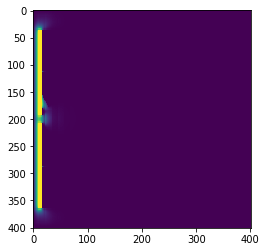

In [20]:
###################PLOTTING EXAMPLES###########
# plot the xy plane for the dc potential
plt.imshow(A[0][:,200,:])#, cmap=plt.cm.get_cmap('viridis', 2))
#plt.axis([70, 90, 290, 310]) #looking at z axis
#plt.axis([0, 50, 290, 310])
#plot the z axis for the RF potential
#plt.plot(plt.imshow(A[0][50,50,:]))

In [21]:
####***grid size in metres, size is number of lattice points. V is a NxNxN grid of potential values Feturns NxNxN grid of Efield magnitudes
def Efield_solve(V,size,grid):
    
    Ex=np.zeros((size,size,size))
    Ey=np.zeros((size,size,size))
    Ez=np.zeros((size,size,size))
    Ex,Ey,Ez = np.gradient(V,grid/size)
    Emag=np.zeros((size,size,size))
    for a in range(0,size):
       for b in range(0,size):
          
          for c in range(0,size):
              Emag[a,b,c] = math.sqrt(Ex[a,b,c]**2+Ey[a,b,c]**2+Ez[a,b,c]**2)
    return Emag
###return pseudopotential in eV. E_field must be NxNxN
def Pseudo_solve(E_field,size,grid,omega,M,Q):
    PseudoeV=np.zeros((size,size,size))
    for a in range(0,size):
       for b in range(0,size):
          for c in range(0,size):
              PseudoeV[a,b,c] = Q**2/(4*M*omega**2)*E_field[a,b,c]**2
    return PseudoeV
###tahes dc potential and pseudo potential to give effective potential energy
def Eeff(PS,Vdc,Q,size):
    PE=np.zeros((size,size,size),dtype=np.long)
    for a in range(0,size):
       for b in range(0,size):
          for c in range(0,size):
              PE[a,b,c]=Q*Vdc[a,b,c]+PS[a,b,c]
    return PE
def Force_field(PE,grid,steps):
    return np.gradient(PE,grid/steps)

In [4]:
(1.6*10**(-19))**2/ (4*2.28*10**-25 *(10000000*2*np.pi)**2)

7.110258501216686e-30

In [22]:
start=time.time()
B=Efield_solve(A[0], 401, 0.052)
print("time elapsed = ",time.time()-start, "seconds")

time elapsed =  107.94838857650757 seconds


In [23]:
####record the start time
start=time.time()
C = Pseudo_solve(B, 401, 0.052, 10085000*2*np.pi, 2.28*10**-25, 1)* 1.6*10**-19
print("time elapsed = ",time.time()-start)


time elapsed =  83.03095555305481


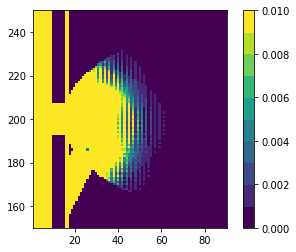

In [25]:
R= plt.imshow(C[:,200,:], cmap=plt.cm.get_cmap('viridis', 10))
plt.colorbar()
plt.clim(0,.01)
plt.axis([1, 90, 150, 250])
plt.show()

#tried splitting into two dieclectrics, bottom voltage, top grounded, with cut off being at t=b2=0.0 -> did not work
#tried three different splittings, did not really seem to work that well, but there was a energy well of about 0.6 eV, but seemed very small

[20, 100, 0, 1]

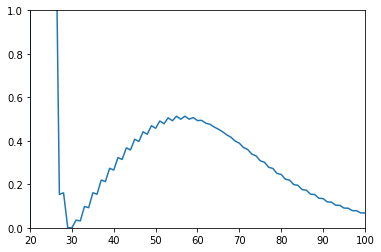

In [154]:
plt.plot(C[200, 200, :])
plt.axis([20, 100, 0, 1])
